### Spark MLLib - Linear Regression

**Description**

- Method to evaluate the relationship between variables.
- Estimates the value of a dependent variable from the values of the independent variables.
- Used when the dependent and independent variables are continuous and have some correlation.
- R-Square measures how close the data is to the regression line (the R-Squar value will be between 0 and 1, and the higher the value, the better).
- Input and output data are used to build the model.
- The linear equation returns the values of the coefficients.
- The linear equation represents the model.

**Pros:** Low cost, fast and excellent for linear relations.

**Cons:** It is applied only to numeric variables, and is sensitive to outliers.

**Application:** It's one of the oldest models, and can be used to solve several problems.

### Predicting MPG Values

MPG will be the target variable and the others will be the features (predictor variables).

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.sql import Row

In [2]:
spSession = SparkSession.builder.master('local').appName('MpgPrediction').getOrCreate()

In [3]:
rddCars01 = sc.textFile('aux/datasets/cars.csv')

**We can cache the RDD to optimize performance.**

In [4]:
rddCars01.cache()

aux/datasets/cars.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
rddCars01.count()

399

In [6]:
rddCars01.take(5)

['MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,NAME',
 '18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst']

In [7]:
header = rddCars01.first()

In [8]:
rddCars02 = rddCars01.filter(lambda row: row != header)

In [9]:
rddCars02.count()

398

### Data Cleaning

Analyzing the dataset, we know that there are missing values for the HP variable. So, we will use a default value for these cases.

In [10]:
hpAvg = sc.broadcast(75.0)

In [11]:
def dataCleaning(strRow):
    global hpAvg
    listAttr = strRow.split(',')
    
    hpValue = hpAvg.value if listAttr[3] == '?' else listAttr[3]
    
    row = Row(
        MPG          = float(listAttr[0]),
        CYLINDERS    = float(listAttr[1]),
        DISPLACEMENT = float(listAttr[2]),
        HP           = float(hpValue),
        WEIGHT       = float(listAttr[4]),
        ACCELERATION = float(listAttr[5]),
        MODEL_YEAR   = float(listAttr[6]),
        NAME         = listAttr[7]
    )
    
    return row

In [12]:
rddCars03 = rddCars02.map(dataCleaning)

In [13]:
rddCars03.cache()

PythonRDD[6] at RDD at PythonRDD.scala:53

In [14]:
rddCars03.take(5)

[Row(MPG=18.0, CYLINDERS=8.0, DISPLACEMENT=307.0, HP=130.0, WEIGHT=3504.0, ACCELERATION=12.0, MODEL_YEAR=70.0, NAME='chevrolet chevelle malibu'),
 Row(MPG=15.0, CYLINDERS=8.0, DISPLACEMENT=350.0, HP=165.0, WEIGHT=3693.0, ACCELERATION=11.5, MODEL_YEAR=70.0, NAME='buick skylark 320'),
 Row(MPG=18.0, CYLINDERS=8.0, DISPLACEMENT=318.0, HP=150.0, WEIGHT=3436.0, ACCELERATION=11.0, MODEL_YEAR=70.0, NAME='plymouth satellite'),
 Row(MPG=16.0, CYLINDERS=8.0, DISPLACEMENT=304.0, HP=150.0, WEIGHT=3433.0, ACCELERATION=12.0, MODEL_YEAR=70.0, NAME='amc rebel sst'),
 Row(MPG=17.0, CYLINDERS=8.0, DISPLACEMENT=302.0, HP=140.0, WEIGHT=3449.0, ACCELERATION=10.5, MODEL_YEAR=70.0, NAME='ford torino')]

### Exploratory Data Analysis

In [15]:
dfCars = spSession.createDataFrame(rddCars03)

In [16]:
dfCars.select('MPG', 'CYLINDERS').describe().show()

+-------+-----------------+------------------+
|summary|              MPG|         CYLINDERS|
+-------+-----------------+------------------+
|  count|              398|               398|
|   mean|23.51457286432161| 5.454773869346734|
| stddev|7.815984312565782|1.7010042445332125|
|    min|              9.0|               3.0|
|    max|             46.6|               8.0|
+-------+-----------------+------------------+



In [17]:
for column in dfCars.columns:
    if not(isinstance(dfCars.select(column).take(1)[0][0], str)):
        print(f"MPG correlation with {column}: {dfCars.stat.corr('MPG', column)}")

MPG correlation with MPG: 1.0
MPG correlation with CYLINDERS: -0.7753962854205548
MPG correlation with DISPLACEMENT: -0.8042028248058979
MPG correlation with HP: -0.774704152349872
MPG correlation with WEIGHT: -0.8317409332443347
MPG correlation with ACCELERATION: 0.42028891210165004
MPG correlation with MODEL_YEAR: 0.5792671330833091


### Data Pre-Processing

**Dense and Sparse Vectors**

Conceptually, both represent the same vector. The sparse vector usually represents the dense vector with a tuple of indices and values. When a dense vector has many zero values, it may be interesting to make it a sparse vector to use less memory.

For example, take the folowing dense vector: **[1, 2, 0, 0, 5, 0, 9, 0, 0]**<br />
As a sparce vector, it would be represented as **[(0, 1, 4, 6), (1, 2, 5 , 9)]**

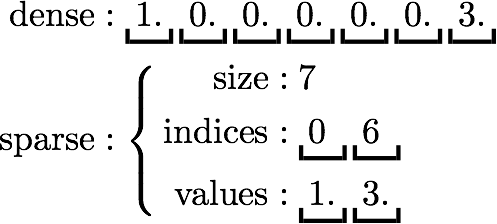

In [18]:
from IPython.display import Image

Image('aux/images/vectors.png')

**Creating a LabeledPoint (target, Vector[features])**<br />
It removes not relevant columns to the model (or with low correlation)

In [19]:
def setLabeledPoint(row):
    labeledPoint = (
        row['MPG'], 
        Vectors.dense([
            row['ACCELERATION'], 
            row['DISPLACEMENT'], 
            row['HP'],
            row['WEIGHT']
        ])
    )
    
    return labeledPoint

In [20]:
rddCars04 = rddCars03.map(setLabeledPoint)

In [21]:
dfCars = spSession.createDataFrame(rddCars04, ['label', 'features'])

In [22]:
dfCars.select('label', 'features').show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 18.0|[12.0,307.0,130.0...|
| 15.0|[11.5,350.0,165.0...|
| 18.0|[11.0,318.0,150.0...|
| 16.0|[12.0,304.0,150.0...|
| 17.0|[10.5,302.0,140.0...|
+-----+--------------------+
only showing top 5 rows



In [23]:
rddCars04.take(5)

[(18.0, DenseVector([12.0, 307.0, 130.0, 3504.0])),
 (15.0, DenseVector([11.5, 350.0, 165.0, 3693.0])),
 (18.0, DenseVector([11.0, 318.0, 150.0, 3436.0])),
 (16.0, DenseVector([12.0, 304.0, 150.0, 3433.0])),
 (17.0, DenseVector([10.5, 302.0, 140.0, 3449.0]))]

### Machine Learning

In [24]:
(dataTraining, dataTest) = dfCars.randomSplit([.7, .3])

In [25]:
dataTraining.count()

284

In [26]:
dataTest.count()

114

In [27]:
dataTraining.count() + dataTest.count() == dfCars.count()

True

In [28]:
linearRegression = LinearRegression(maxIter = 10)

In [29]:
model = linearRegression.fit(dataTraining)

In [30]:
model

LinearRegressionModel: uid=LinearRegression_92c82f202721, numFeatures=4

In [31]:
print(f'Coefficients: {str(model.coefficients)}')
print(f'Intercept: {str(model.intercept)}')

Coefficients: [-0.29545441909545384,-0.00965795761865128,-0.05754189918120035,-0.0046291606424957886]
Intercept: 49.52971710194131


In [32]:
predictions = model.transform(dataTest)

In [33]:
predictions.select('features', 'prediction').show(5)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[18.5,304.0,193.0...| 8.117016530343683|
|[11.0,350.0,180.0...|15.580646878642732|
|[14.0,400.0,150.0...| 9.766971579412932|
|[11.0,455.0,225.0...| 6.019446118638257|
|[11.0,440.0,215.0...| 7.739633173509112|
+--------------------+------------------+
only showing top 5 rows



In [34]:
evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'label', metricName = 'r2')

In [35]:
evaluator.evaluate(predictions)

0.7006587000445249